# Quantified Self Keylogging

Some aggregate data analysis is of keylogging is performed in this document. Magical plots are here to reveal underlying patterns of behaviour and magnificently elegant explanations of how unproductive I'm being over this semester! : )

In [1]:
# import necessary modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from datetime import timedelta
import os
from __future__ import print_function
import googleapiclient.discovery as discovery
from oauth2client import client
from oauth2client import tools
from oauth2client.file import Storage
from mycolorpy import colorlist as mcp
import mpld3
from matplotlib.dates import DateFormatter
from matplotlib import cm
from matplotlib import colors as cls


# Define some useful constats
LOG_FILE    = '/Users/panos/Documents/NYU/1. Courses/Quantified_Self/Assignment 1/CODE/Log/log.txt'
LOG_FILE_BU = '/Users/panos/Documents/NYU/1. Courses/Quantified_Self/Assignment 1/CODE/Log/Backup/log.txt'
CONVERT     =  timedelta(hours=4)
COLORS      = {'1': '#ac725e', '2': '#d06b64', '3': '#f83a22', '4': '#fa573c', '5': '#ff7537', '6': '#ffad46', '7': '#42d692', '8': '#16a765', '9': '#7bd148', '10': '#b3dc6c', '11': '#fbe983', '12': '#fad165', '13': '#92e1c0', '14': '#9fe1e7', '15': '#9fc6e7', '16': '#4986e7', '17': '#9a9cff', '18': '#b99aff', '19': '#c2c2c2', '20': '#cabdbf', '21': '#cca6ac', '22': '#f691b2', '23': '#cd74e6', '24': '#a47ae2'}
COLORS      = {str(i):color for i,color in enumerate(mcp.gen_color(cmap='hsv',n=20))}
KEYMAP      = {key:label for label,key in pd.read_csv('keymap.txt').to_numpy()}


In [2]:
# Some google api functions
# try:
#     import argparse
#     flags = argparse.ArgumentParser(parents=[tools.argparser]).parse_args()
# except ImportError:
flags = None
 
SCOPES = 'https://www.googleapis.com/auth/calendar.readonly'
CLIENT_SECRET_FILE = 'qs-cred.json'
APPLICATION_NAME = 'Quantified Self A1'
 
 
def get_credentials():
    """Gets valid user credentials from storage.
 
    If nothing has been stored, or if the stored credentials are invalid,
    the OAuth2 flow is completed to obtain the new credentials.
 
    Returns:
        Credentials, the obtained credential.
    """
    home_dir = os.path.expanduser('~')
    credential_dir = os.path.join(home_dir, '.credentials')
    if not os.path.exists(credential_dir):
        os.makedirs(credential_dir)
    credential_path = os.path.join(credential_dir,
                                   'calendar-python-quickstart.json')
 
    store = Storage(credential_path)
    credentials = store.get()
    if not credentials or credentials.invalid:
        flow = client.flow_from_clientsecrets(CLIENT_SECRET_FILE, SCOPES)
        flow.user_agent = APPLICATION_NAME
        if flags:
            credentials = tools.run_flow(flow, store, flags)
        else:  # Needed only for compatibility with Python 2.6
            credentials = tools.run(flow, store)
        print('Storing credentials to ' + credential_path)
    return credentials

def get_events(time_min,time_max):
    creds = get_credentials()

    service = discovery.build('calendar', 'v3', credentials=creds)
    # print(service.colors().get().execute())

    # Call the Calendar API
    # now = datetime.datetime.utcnow().isoformat() + 'D'  # 'Z' indicates UTC time
    events_result = service.events().list(calendarId='primary', timeMin=time_min,
                                            timeMax=time_max, singleEvents=True,
                                            orderBy='startTime').execute()
                                            
    events = events_result.get('items', [])

    if not events:
        print('No upcoming events found.')
        return

    # Prints the start and name of the next 10 events
    start   = []
    end     = []
    summary = []
    colors  = []
    for event in events:
        # print(event,'\n')
        start.append(event['start'].get('dateTime', event['start'].get('date')))
        end.append(event['end'].get('dateTime', event['end'].get('date')))
        summary.append(event['summary'])

        if 'colorId' in event.keys():
            colors.append(event['colorId'])
        else:
            colors.append('1')


    start  = [datetime.datetime.fromisoformat(date) + CONVERT for date in start]
    end    = [datetime.datetime.fromisoformat(date) + CONVERT for date in end]
    colors = [COLORS[color] for color in colors]

    return start,end,summary,colors
 

In [18]:
# import the data into a dataset
def read_data(filename:str):
    # First regularize the file, by removing stupid formatting
    file = open(filename)       # Open the file
    lines = file.readlines()    # Read the data
    file.close()                # Close it to avoid interference

    # Initialize output array
    output = []
    chars  = []
    for line in lines:
        if line == '' or line == '\n': continue     # Skip invalid lines
        line    = line.replace(',,43',',43')        # Handle special cases
        split   = line.split(',')                   # Split the line
        
        # Append output
        chars.append(split[0])
        output.append(split[1:])

    return np.array(chars),np.array(output,dtype=int).T

rms = {'12':0.6,'13':0.85,'14':0.4,'15':0.5,'0':0.4,'49':.9,'1':0.8,'2':0.6}

def process(filename:str,rms=rms):
    chars,data = read_data(filename)
    dataset = np.array([chars,*data]).T

    new_dataset = []
    for x in dataset:
        if x[1] in rms.keys():
            p = np.random.rand()
            if p > rms[x[1]]:
                new_dataset.append(x)
        
        else:
            new_dataset.append(x)

    return np.array(new_dataset)

In [19]:
# Obtain the data
# chars,data = read_data(LOG_FILE_BU)
dataset = process(LOG_FILE_BU)
chars,data = dataset.T[0],np.array((dataset.T[1:,]).tolist(),dtype=int)

# Create the dates
dates = np.array([datetime.datetime.fromtimestamp(date/100000) for date in data[1]])

# Obtain my calendar events
start, end, events, colors = get_events((dates[0]-CONVERT).isoformat() + 'Z',(dates[-1]-CONVERT).isoformat() + 'Z')

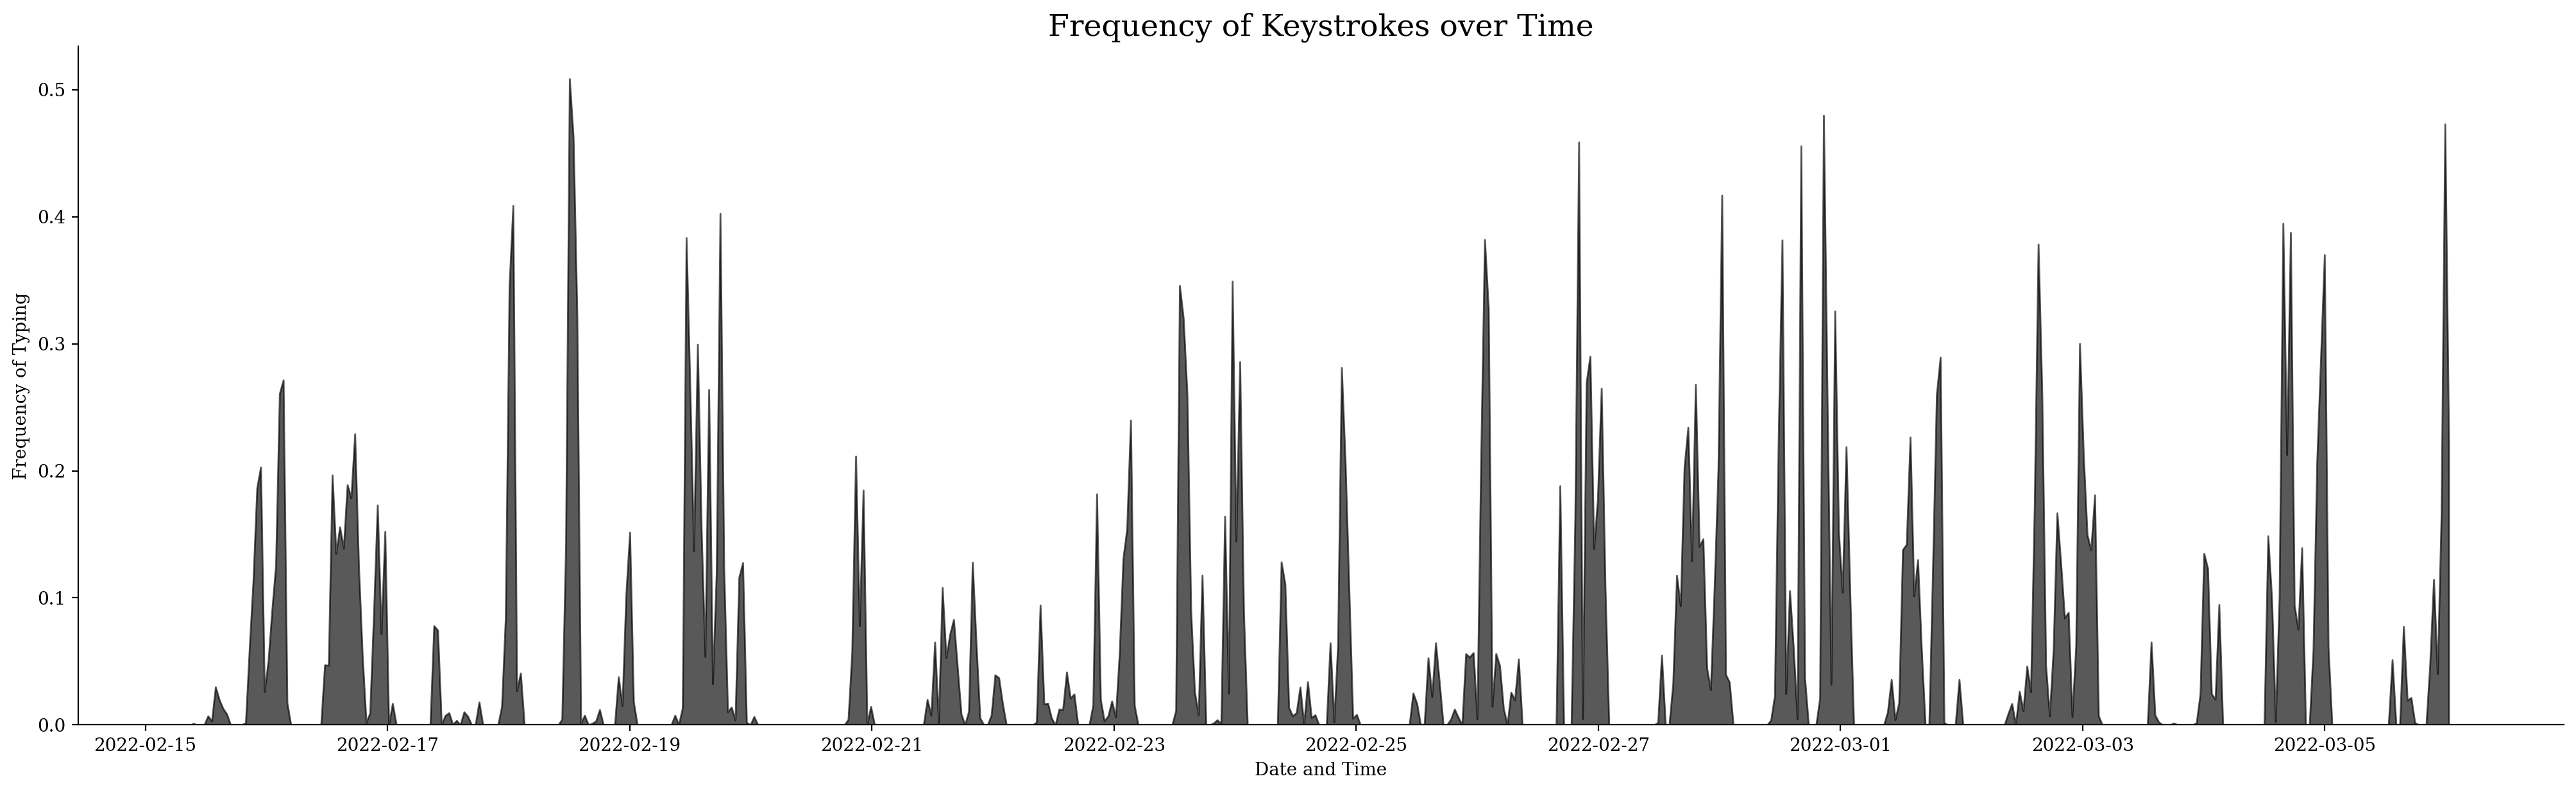

In [20]:
plt.rcParams["font.family"] = "serif"
# Plot a little histogram of the data 
# Create a figure
fig = plt.figure(figsize=(25,7),dpi=200)
ax = fig.add_subplot(111)

# Plot the histogram
n,x,_ = ax.hist(dates,bins=600,alpha=0,color='k',density=True,histtype='stepfilled');
bins = 0.5*(x[1:]+x[:-1])
plt.fill_between(bins,n,color='k',alpha=0.65)


# Some customization
ax.set_xlabel('Date and Time',fontsize=10);
ax.set_ylabel('Frequency of Typing',fontsize=10);

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Frequency of Keystrokes over Time',fontsize=17);

mpld3.save_html(fig,'test.html')

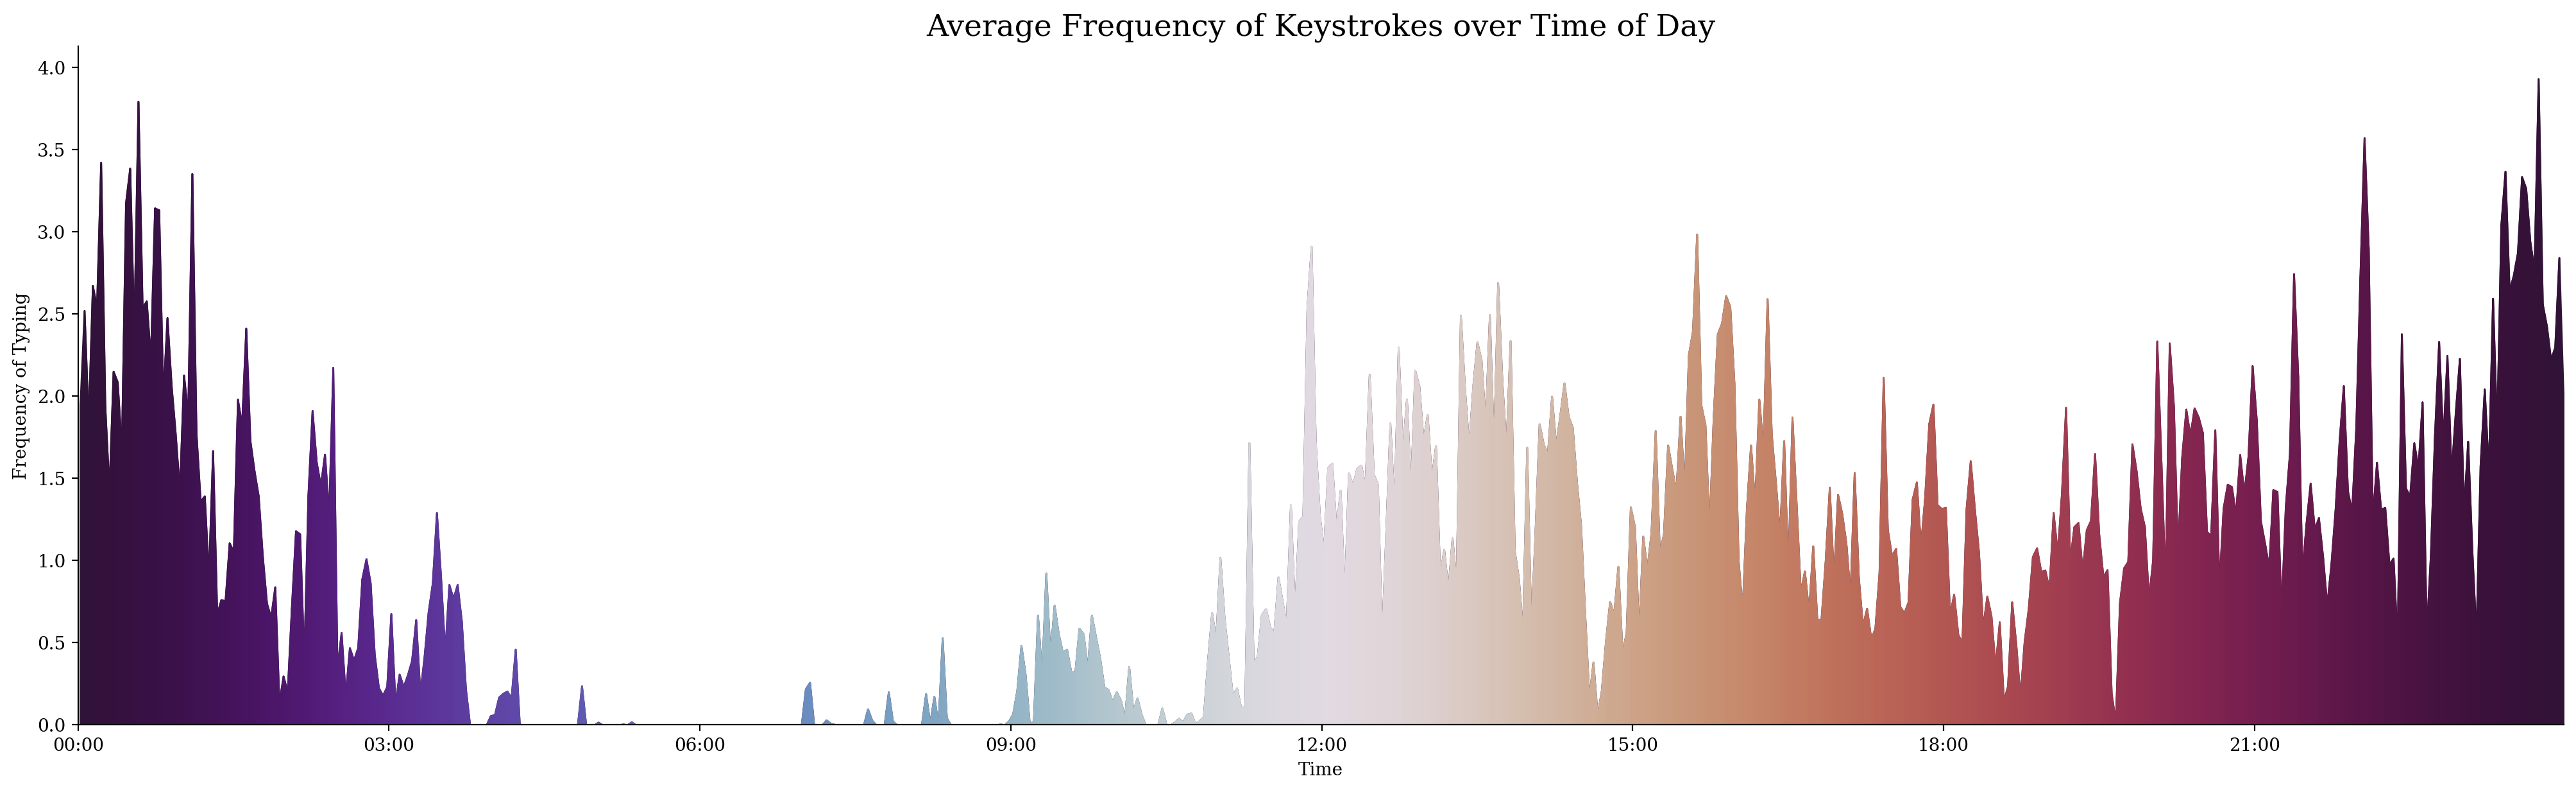

In [21]:
plt.rcParams["font.family"] = "serif"
# Plot a little histogram of the data 
# Create a figure
fig = plt.figure(figsize=(25,7),dpi=200)
ax = fig.add_subplot(111)

# Plot the histogram
times = [datetime.datetime.strptime(date.strftime("%H:%M:%S"),"%H:%M:%S") for date in dates]

n,x,_ = ax.hist(times,bins=600,alpha=0,color='k',density=True,histtype='stepfilled');
bins = 0.5*(x[1:]+x[:-1])

N=500
splits = np.arange(N+1)/N
cmap    = cm.get_cmap('twilight_shifted')
ccolors = [cls.to_hex(cmap(split)) for split in splits]
splits = np.array((splits*len(bins)).tolist(),dtype=int)

for i in range(N-1):
    if i == 0:
        plt.fill_between(bins,n,color=ccolors[i],where= (bins <= bins[splits[i]]) + (bins >= bins[splits[-i]]),alpha=1)
    else:
        plt.fill_between(bins,n,color=ccolors[i],where= (bins >= bins[splits[i]]) * (bins <= bins[splits[i+1]]),alpha=1)

# Some customization
ax.set_xlabel('Time',fontsize=10);
ax.set_ylabel('Frequency of Typing',fontsize=10);

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Average Frequency of Keystrokes over Time of Day',fontsize=17);

# mpld3.save_html(fig,'test.html')
date_form = DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_form)
midnight_   = datetime.datetime.strptime("00:00","%H:%M")
midnight__  = datetime.datetime.strptime("23:59","%H:%M")
ax.set_xlim(midnight_,midnight__);

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127860 (\N{FORK AND KNIFE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


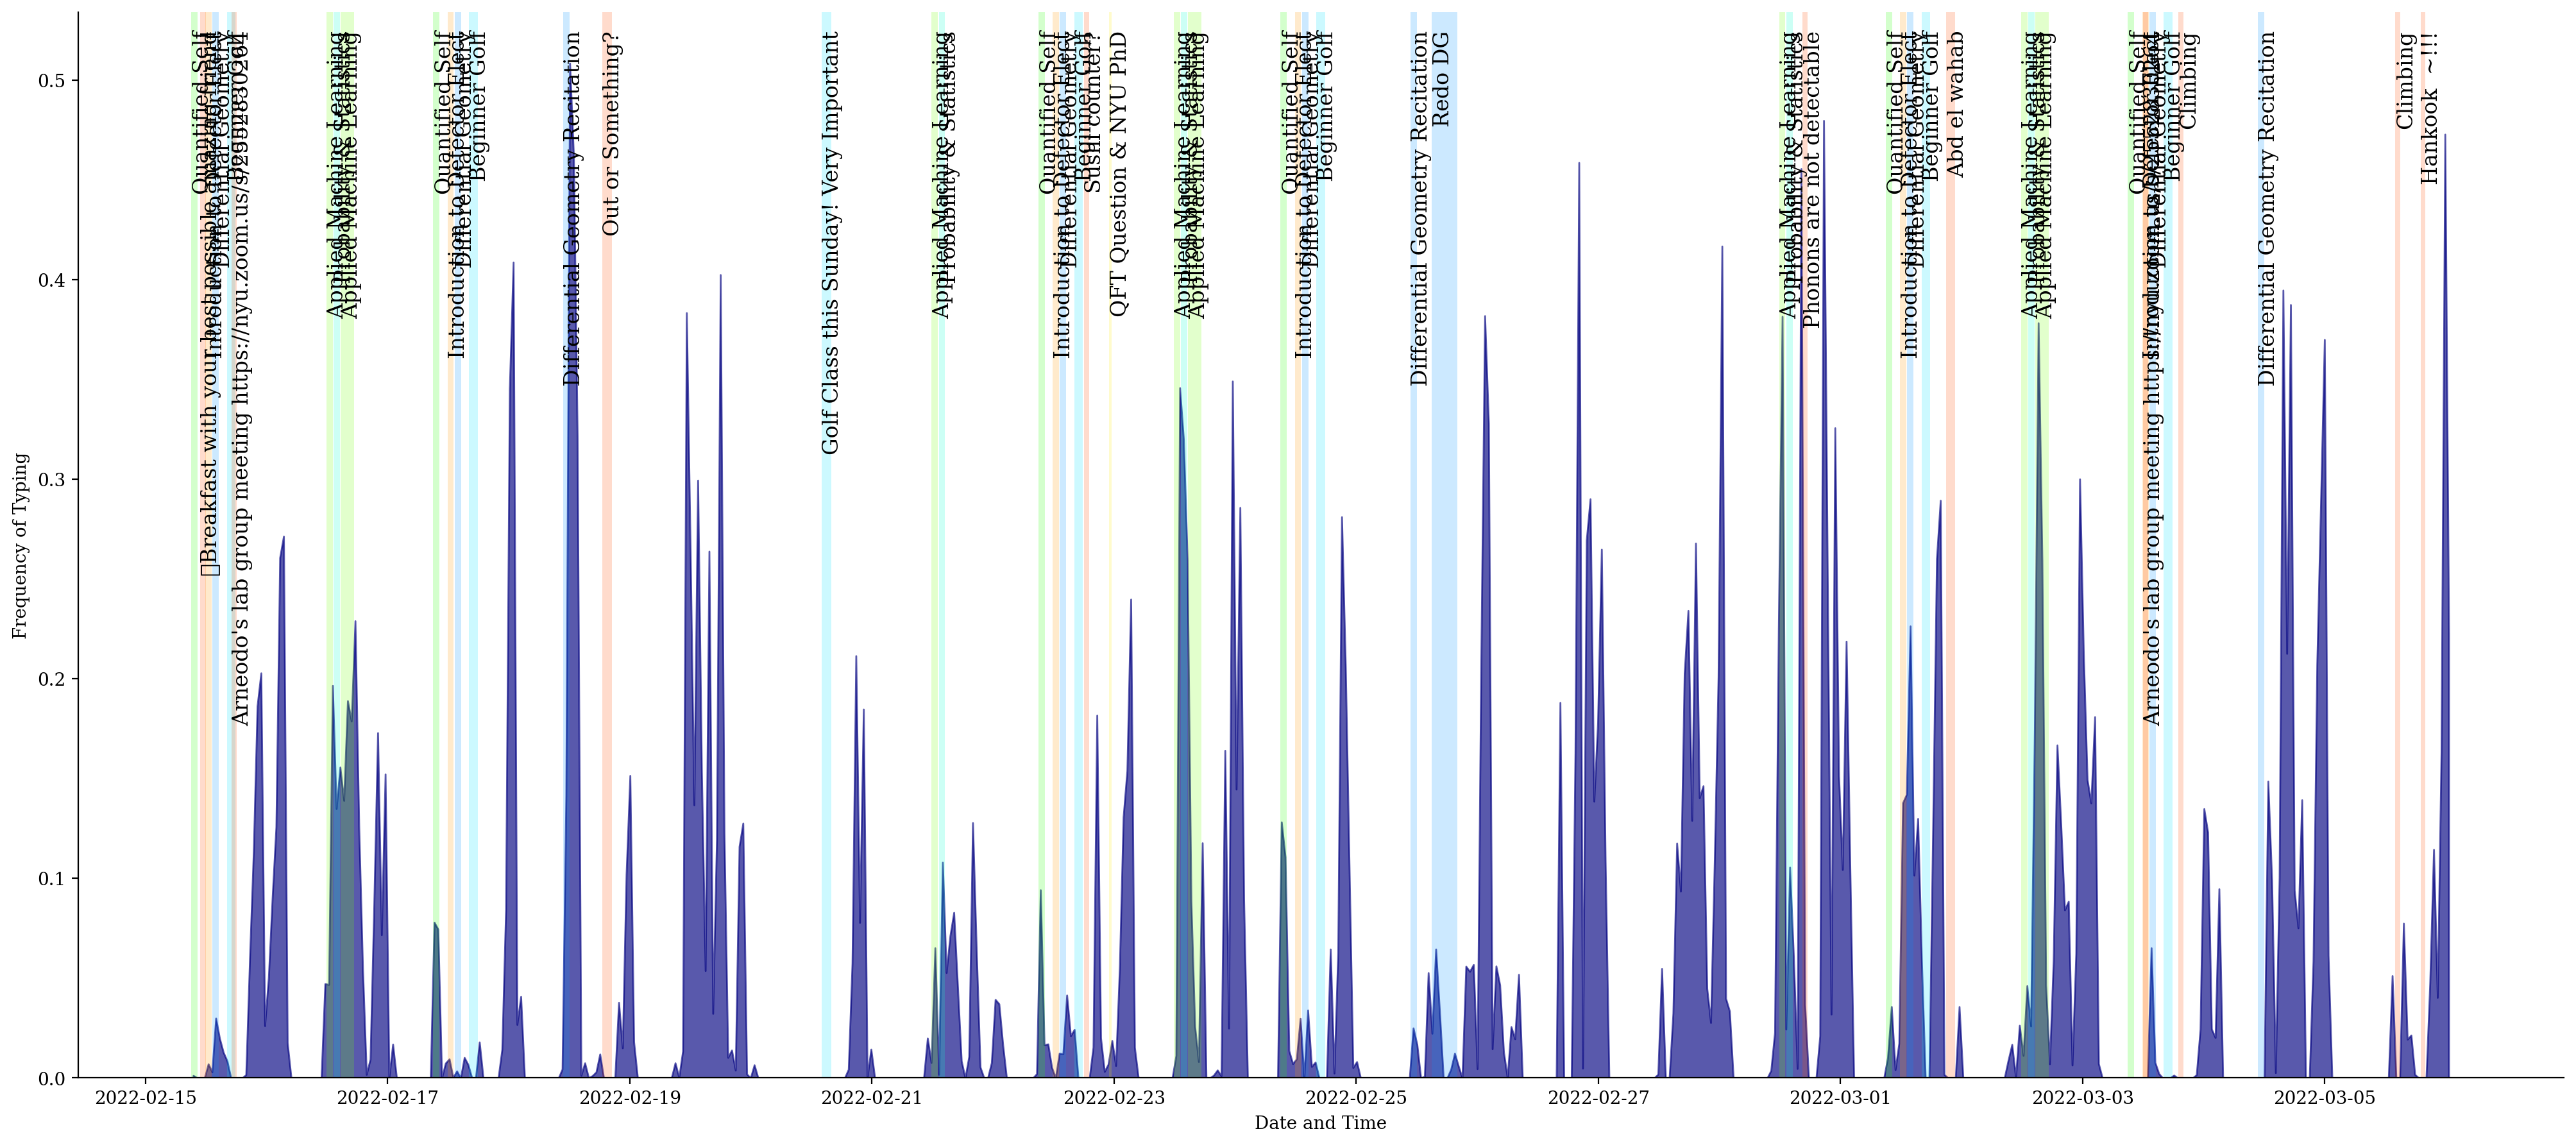

In [22]:
plt.rcParams["font.family"] = "serif"
# Plot a little histogram of the data 
# Create a figure
fig = plt.figure(figsize=(25,11),dpi=200)
ax = fig.add_subplot(111)

# Plot the histogram
n,x,_ = ax.hist(dates,bins=600,alpha=0,color='k',density=True,histtype='stepfilled');
bins = 0.5*(x[1:]+x[:-1])
plt.fill_between(bins,n,color='navy',alpha=0.65)

# Plot the boxes 
for s, e, c, event in zip(start,end, colors,events):
    ax.axvspan(s,e,alpha=0.2,facecolor=c)
    ax.annotate(event,xy=(s,ax.get_ylim()[1]),rotation_mode="anchor", xytext=(12, -10),textcoords='offset points',rotation=90,fontsize=12,horizontalalignment='right',verticalalignment='bottom')

# Some customization
ax.set_xlabel('Date and Time');
ax.set_ylabel('Frequency of Typing');

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Export this plot to HTML
html_str = mpld3.fig_to_html(fig)
Html_file= open("index.html","w")
Html_file.write(html_str)
Html_file.close()

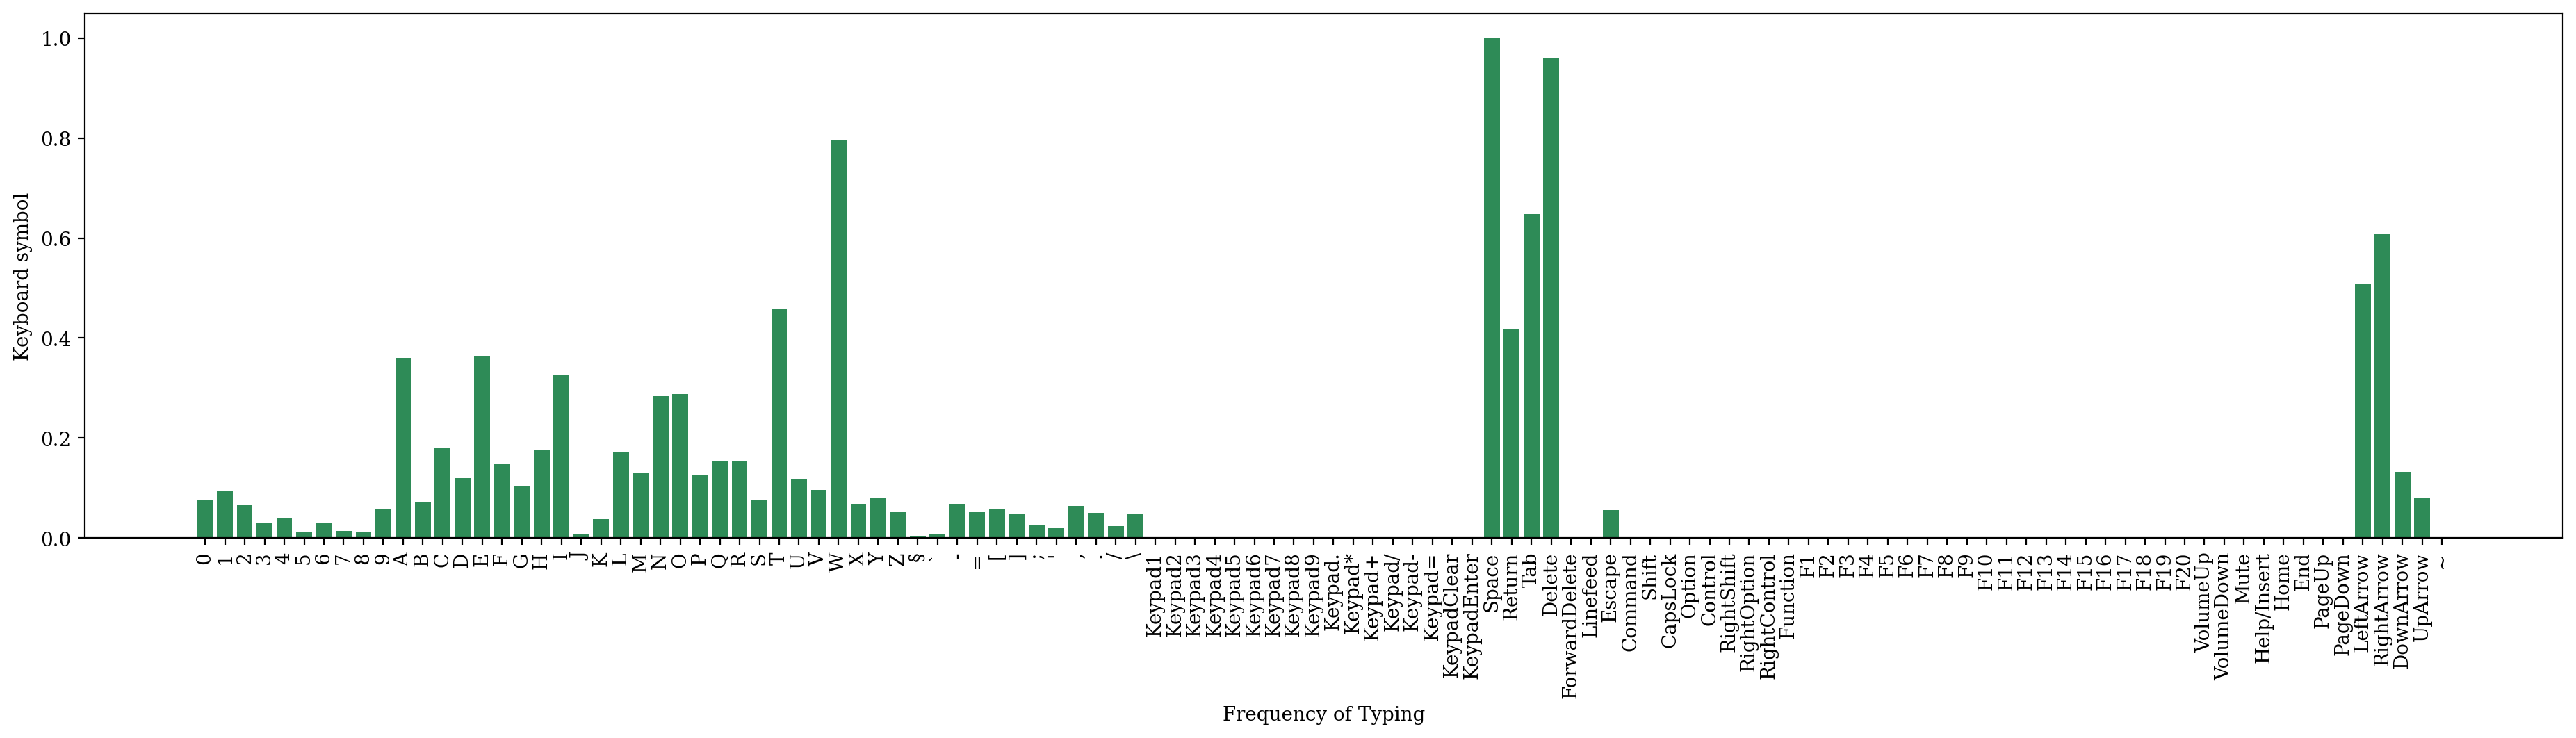

In [23]:
# Plot a little histogram of the data 
# Create a figure
fig = plt.figure(figsize=(23,5),dpi=200)
ax = fig.add_subplot(111)

# Plot the histogram
# ax.hist(data[0],bins=len(np.unique(data[0])),color='k',density=True);
labels, freq = np.unique(np.append(data[0],list(KEYMAP.keys()),axis=0),return_counts=True)
labels = np.array([KEYMAP[l] for l in labels])

# reorder the label stuff
idx     = [list(labels).index(l) for l in list(KEYMAP.values())]
labels  = labels[idx]
freq    = freq[idx]/np.max(freq)

ax.bar(labels,freq,color='seagreen');

ax.set_ylabel('Keyboard symbol');
ax.set_xlabel('Frequency of Typing');
plt.xticks(rotation=90);

In [49]:
# Create the keyboard
keyboard = """<svg id="s" viewBox="0 0 800 498">
    <g fill="#222">
        <rect x="132.9" y="339.3" width="40.1" height="40.1" rx="2.5"   fill="#__6__"></rect>
        <rect x="186.8" y="339.4" width="40.1" height="40.1" rx="2.5"   fill="#__7__"></rect>
        <rect x="240.6" y="339.4" width="40.1" height="40.1" rx="2.5"   fill="#__8__"></rect>
        <rect x="294.5" y="339.4" width="40.1" height="40.1" rx="2.5"   fill="#__9__"></rect>
        <rect x="348.4" y="339.4" width="40.1" height="40.1" rx="2.5"   fill="#__11__"></rect>
        <rect x="402.3" y="339.4" width="40.1" height="40.1" rx="2.5"   fill="#__45__"></rect>
        <rect x="456.2" y="339.4" width="40.1" height="40.1" rx="2.5"   fill="#__46__"></rect>
        <rect x="510" y="339.4" width="40.1" height="40.1" rx="2.5"     fill="#__43__"></rect>
        <rect x="563.9" y="339.4" width="40.1" height="40.1" rx="2.5"   fill="#__47__"></rect>
        <rect x="617.8" y="339.4" width="40.1" height="40.1" rx="2.5"   fill="#__44__"></rect>
        <rect x="3.8" y="339.4" width="115.3" height="40.1" rx="2.5"    fill="#__57__"></rect>
        <rect x="671.7" y="339.4" width="115.3" height="40.1" rx="2.5"  fill="#__60__"></rect>
        <rect x="313.4" y="39.9" width="40.3" height="35.2" rx="2.5"    fill="#__96__"></rect>
        <rect x="375.3" y="39.9" width="40.3" height="35.2" rx="2.5"    fill="#__97__"></rect>
        <rect x="437.2" y="39.9" width="40.3" height="35.2" rx="2.5"    fill="#__98__"></rect>
        <rect x="499.1" y="39.9" width="40.3" height="35.2" rx="2.5"    fill="#__100__"></rect>
        <rect x="561" y="39.9" width="40.3" height="35.2" rx="2.5"      fill="#__101__"></rect>
        <rect x="623" y="39.9" width="40.3" height="35.2" rx="2.5"      fill="#__109__"></rect>
        <rect x="684.9" y="39.9" width="40.3" height="35.2" rx="2.5"    fill="#__103__"></rect>
        <rect x="746.8" y="39.9" width="40.3" height="35.2" rx="2.5"    fill="#__111__"></rect>
        <rect x="65.7" y="39.9" width="40.3" height="35.2" rx="2.5"     fill="#__122__"></rect>
    </g>
    <g fill="#222">
        <rect x="127.6" y="39.9" width="40.3" height="35.2" rx="2.5"    fill="#__120__"></rect>
        <rect x="189.5" y="39.9" width="40.3" height="35.2" rx="2.5"    fill="#__99__"></rect>
        <rect x="202.4" y="46.6" width="6.5" height="5.2" rx="0" stroke="#fff" stroke-width=".5" fill="#__99__"></rect>
        <rect x="211" y="45.3" width="5.9" height="6.4" rx="0" stroke="#fff" stroke-width=".5"   fill="#__99__"></rect>
    </g>
    <g fill="#222">
        <rect x="251.4" y="39.9" width="40.3" height="35.2" rx="2.5" fill="#__118__"></rect>
        <g stroke="#fff" stroke-linecap="square" stroke-width=".5">
            <rect x="263.8" y="44.7" width="2.8" height="2.8"></rect>
            <rect x="268" y="44.7" width="2.8" height="2.8"></rect>
            <rect x="272.3" y="44.7" width="2.8" height="2.8"></rect>
            <rect x="276.5" y="44.7" width="2.8" height="2.8"></rect>
            <rect x="263.8" y="49" width="2.8" height="2.8"></rect>
            <rect x="268" y="49" width="2.8" height="2.8"></rect>
            <rect x="272.3" y="49" width="2.8" height="2.8"></rect>
            <rect x="276.5" y="49" width="2.8" height="2.8"></rect>
        </g>
    </g>
    <g fill="none" stroke="#222" stroke-width=".5">
        <rect x="63.2" y="4.7" width="45.3" height="73" rx="2.5"></rect>
        <g stroke="#fff">
            <circle cx="85.8" cy="48.8" r="1.7"></circle>
            <path d="m85.8 46.1v-.5"></path>
            <path d="m85.8 51.95v-.5"></path>
            <path d="m88.97 48.8h-.5"></path>
            <path d="m83.16 48.78h-.5"></path>
            <path d="m83.9 46.9-.37-.4"></path>
            <path d="m88 51-.37-.37"></path>
            <path d="m88 46.5-.374.4"></path>
            <path d="m83.9 50.65-.374.37"></path>
            <path d="m147.7 54.4v-1.4"></path>
            <circle cx="147.7" cy="50" r="2.3"></circle>
            <path d="m147.7 46.86v-1.4"></path>
            <path d="m152.2 49.96h-1.4"></path>
            <path d="m144.6 49.96h-1.4"></path>
            <path d="m145.5 47.77-.98-1"></path>
            <path d="m150.88 53.1-1-1"></path>
            <path d="m150.88 46.8-.98.98"></path>
            <path d="m145.5 52.1-.98.98"></path>
        </g>
        <rect x="125" y="4.7" width="45.3" height="73" rx="2.5"></rect>
        <rect x="187" y="4.7" width="45.3" height="73" rx="2.5"></rect>
        <rect x="248.9" y="4.7" width="45.3" height="73" rx="2.5"></rect>
        <rect x="130.4" y="316.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="184.2" y="316.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="238.1" y="316.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="292" y="316.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="345.9" y="316.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="399.8" y="316.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="453.7" y="316.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="507.6" y="316.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="561.4" y="316.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="615.3" y="316.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="1.3" y="316.8" width="120.4" height="65.2" rx="2.5"></rect>
        <rect x="669.2" y="316.8" width="120.4" height="65.2" rx="2.5"></rect>
        <rect x="310.8" y="17.3" width="45.3" height="60.4" rx="2.5"></rect>
        <rect x="372.8" y="17.3" width="45.3" height="60.4" rx="2.5"></rect>
        <rect x="434.7" y="17.3" width="45.3" height="60.4" rx="2.5"></rect>
        <rect x="496.6" y="17.3" width="45.3" height="60.4" rx="2.5"></rect>
        <rect x="558.5" y="17.3" width="45.3" height="60.4" rx="2.5"></rect>
        <rect x="620.4" y="17.3" width="45.3" height="60.4" rx="2.5"></rect>
        <rect x="682.4" y="17.3" width="45.3" height="60.4" rx="2.5"></rect>
        <rect x="744.3" y="17.3" width="45.3" height="60.4" rx="2.5"></rect>
        <rect x="1.3" y="17.3" width="45.3" height="60.4" rx="2.5"></rect>
        <rect x="1.3" y="88.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="55.3" y="88.6" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="109.4" y="88.6" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="163.5" y="88.6" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="217.5" y="88.6" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="271.6" y="88.6" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="325.7" y="88.4" width="45.2" height="65.3" rx="2.5"></rect>
        <rect x="379.9" y="88.6" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="433.9" y="88.6" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="488" y="88.6" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="542" y="88.6" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="596.2" y="88.9" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="650.2" y="88.9" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="704.3" y="88.9" width="85.3" height="65.2" rx="2.5"></rect>
        <rect x="95.5" y="164.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="149.5" y="164.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="203.6" y="164.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="257.7" y="164.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="311.8" y="164.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="365.9" y="164.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="419.9" y="164.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="474" y="164.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="528.1" y="164.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="582.2" y="164.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="636.3" y="164.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="690.3" y="164.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="744.4" y="164.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="1.3" y="164.8" width="85.3" height="65.2" rx="2.5"></rect>
        <rect x="1.2" y="392.8" width="41.8" height="60.4" rx="2.3"></rect>
        <rect x="51" y="392.8" width="65.2" height="65.2" rx="2.5"></rect>
        <rect x="124.3" y="392.8" width="65.2" height="65.2" rx="2.5"></rect>
        <rect x="197.6" y="392.8" width="85.3" height="65.2" rx="2.5"></rect>
        <rect x="587.8" y="392.8" width="65.2" height="65.2" rx="2.5"></rect>
        <rect x="494.5" y="392.8" width="85.3" height="65.2" rx="2.5"></rect>
        <rect x="290.9" y="392.8" width="195.6" height="65.2" rx="2.5"></rect>
        <rect x="107.1" y="240.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="160.4" y="240.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="213.6" y="240.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="266.9" y="240.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="320" y="240.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="373.3" y="240.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="426.6" y="240.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="479.8" y="240.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="533" y="240.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="586.3" y="240.8" width="45.1" height="65.2" rx="2.5"></rect>
        <rect x="639.5" y="240.8" width="45.1" height="65.2" rx="2.5"></rect>
        <path
            d="m3.758 240.8h92.773c1.389 0 2.5 1.1 2.5 2.5v60.177c0 1.389-1.1 2.5-2.5 2.5h-92.773c-1.389 0-2.5-1.1-2.5-2.5v-60.177c0-1.389 1.1-2.5 2.5-2.5z">
        </path>
        <rect x="692.7" y="240.8" width="96.8" height="65" rx="2.5"></rect>
        <rect x="707.8" y="386.7" width="44.3" height="54" rx="2.5"></rect>
        <rect x="707.8" y="443.2" width="44.3" height="54" rx="2.5"></rect>
        <rect x="661" y="403.9" width="44.3" height="54" rx="2.5"></rect>
        <rect x="754.5" y="403.9" width="44.3" height="54" rx="2.5"></rect>
    </g>
    <g fill="#222">
        <rect x="696" y="263.5" width="89.4" height="38.9" rx="2.4"></rect>
        <rect x="709.7" y="409" width="39.3" height="29.5" rx="2.6"></rect>
        <rect x="709.7" y="446.2" width="39.3" height="29.5" rx="2.4"></rect>
        <rect x="756.4" y="426.5" width="39.3" height="29.5" rx="2.4"></rect>
        <rect x="663" y="426.5" width="39.3" height="29.5" rx="2.4"></rect>
        <rect x="3.8" y="39.9" width="40.1" height="35.2" rx="2.4"      fill="#__53__"></rect>
        <rect x="3.8" y="111.3" width="40.1" height="40.1" rx="2.5"     fill="#__50__"></rect>
        <rect x="57.8" y="111.2" width="40.1" height="40.1" rx="2.5"    fill="#__18__"></rect>
        <rect x="111.9" y="111.2" width="40.1" height="40.1" rx="2.5"   fill="#__19__"></rect>
        <rect x="166" y="111.2" width="40.1" height="40.1" rx="2.5"     fill="#__20__"></rect>
        <rect x="220" y="111.2" width="40.1" height="40.1" rx="2.5"     fill="#__21__"></rect>
        <rect x="274.1" y="111.2" width="40.1" height="40.1" rx="2.5"   fill="#__23__"></rect>
        <rect x="328.2" y="111.5" width="40.2" height="40.2" rx="2.5"   fill="#__22__"></rect>
        <rect x="382.4" y="111.2" width="40.1" height="40.1" rx="2.5"   fill="#__26__"></rect>
        <rect x="436.5" y="111.2" width="40.1" height="40.1" rx="2.5"   fill="#__28__"></rect>
        <rect x="490.5" y="111.2" width="40.1" height="40.1" rx="2.5"   fill="#__25__"></rect>
        <rect x="544.6" y="111.2" width="40.1" height="40.1" rx="2.5"   fill="#__29__"></rect>
        <rect x="598.7" y="111.4" width="40.1" height="40.1" rx="2.5"   fill="#__27__"></rect>
        <rect x="652.7" y="111.4" width="40.1" height="40.1" rx="2.5"   fill="#__24__"></rect>
        <rect x="706.8" y="111.4" width="80.2" height="40.1" rx="2.5"   fill="#__51__"></rect>
        <rect x="98" y="187.4" width="40.1" height="40.1" rx="2.5"      fill="#__12__"></rect>
        <rect x="152" y="187.4" width="40.1" height="40.1" rx="2.5"     fill="#__13__"></rect>
        <rect x="206.1" y="187.4" width="40.1" height="40.1" rx="2.5"   fill="#__14__"></rect>
        <rect x="260.2" y="187.4" width="40.1" height="40.1" rx="2.5"   fill="#__15__"></rect>
        <rect x="314.3" y="187.4" width="40.1" height="40.1" rx="2.5"   fill="#__17__"></rect>
        <rect x="368.4" y="187.4" width="40.1" height="40.1" rx="2.5"   fill="#__16__"></rect>
        <rect x="422.4" y="187.4" width="40.1" height="40.1" rx="2.5"   fill="#__32__"></rect>
        <rect x="476.5" y="187.4" width="40.1" height="40.1" rx="2.5"   fill="#__34__"></rect>
        <rect x="530.6" y="187.4" width="40.1" height="40.1" rx="2.5"   fill="#__31__"></rect>
        <rect x="584.7" y="187.4" width="40.1" height="40.1" rx="2.5"   fill="#__35__"></rect>
        <rect x="638.8" y="187.4" width="40.1" height="40.1" rx="2.5"   fill="#__33__"></rect>
        <rect x="692.9" y="187.4" width="40.1" height="40.1" rx="2.5"   fill="#__30__"></rect>
        <rect x="746.9" y="187.4" width="40" height="40" rx="2.4"       fill="#__42__"></rect>
        <rect x="3.8" y="187.4" width="80.2" height="40.1" rx="2.5"     fill="#__48__"></rect>
        <rect x="3.6" y="413.7" width="37.2" height="37.2" rx="2.3"     fill="#__63__"></rect>
        <rect x="53.6" y="415.3" width="60.2" height="40.1" rx="2.5"    fill="#__59__"></rect>
        <rect x="126.8" y="415.3" width="60.2" height="40.1" rx="2.5"   fill="#__58__"></rect>
        <rect x="200" y="415.3" width="80.2" height="40.1" rx="2.5"     fill="#__55__"></rect>
        <rect x="590.3" y="415.3" width="60.2" height="40.1" rx="2.5"   fill="#__61__"></rect>
        <rect x="497" y="415.3" width="80.2" height="40.1" rx="2.5"     fill="#__55__"></rect>
        <rect x="293.4" y="415.3" width="190.6" height="40.1" rx="2.5"  fill="#__49__"></rect>
        <rect x="109.7" y="263.4" width="40.1" height="40.1" rx="2.5"   fill="#__0__"></rect>
        <rect x="162.9" y="263.4" width="40.1" height="40.1" rx="2.5"   fill="#__1__"></rect>
        <rect x="216.1" y="263.4" width="40.1" height="40.1" rx="2.5"   fill="#__2__"></rect>
        <rect x="269.4" y="263.4" width="40.1" height="40.1" rx="2.5"   fill="#__3__"></rect>
        <rect x="322.6" y="263.4" width="40.1" height="40.1" rx="2.5"   fill="#__5__"></rect>
        <rect x="375.8" y="263.4" width="40.1" height="40.1" rx="2.5"   fill="#__4__"></rect>
        <rect x="429" y="263.4" width="40.1" height="40.1" rx="2.5"     fill="#__38__"></rect>
        <rect x="482.3" y="263.4" width="40.1" height="40.1" rx="2.5"   fill="#__40__"></rect>
        <rect x="535.5" y="263.4" width="40.1" height="40.1" rx="2.5"   fill="#__37__"></rect>
        <rect x="588.8" y="263.4" width="40.1" height="40.1" rx="2.5"   fill="#__41__"></rect>
        <rect x="642" y="263.4" width="40.1" height="40.1" rx="2.5"     fill="#__39__"></rect>
        <rect x="3.8" y="263.4" width="92.3" height="40.1" rx="2.5"     fill="#__57__"></rect>
        <rect x="696.8" y="262.8" width="89.4" height="38.9" rx="2.4"   fill="#__36__"></rect>
        <rect x="710.2" y="408.5" width="39.3" height="29.5" rx="2.6"   fill="#__126__"></rect>
        <rect x="710.2" y="445.6" width="39.3" height="29.5" rx="2.4"   fill="#__125__"></rect>
        <rect x="756.95" y="425.99" width="39.3" height="29.5" rx="2.4" fill="#__124__"></rect>
        <rect x="663.5" y="426" width="39.3" height="29.5" rx="2.4"     fill="#__123__"></rect>
    </g>
    <g fill="#fff">
        <path d="m734.15 427.9-4.2-9.2948-4.2 9.3"></path>
        <path d="m734.15 455.7-4.2 9.2948-4.2-9.3"></path>
        <path d="m771.66 436.76 9.9 3.98-9.9 3.98"></path>
        <path d="m688.1 444.7-9.9-3.98 9.9-3.98"></path>
    </g>
    <g font-size="3.6px"><text x="3.9" y="26.5">
            <tspan x="3.9" y="26.5">key code</tspan>
        </text><text x="65.9" y="14.5">
            <tspan x="65.9" y="14.5">key code</tspan>
        </text><text x="65.8" y="26.8">
            <tspan x="65.8" y="26.8">key code</tspan>
        </text><text x="127.8" y="26.5">
            <tspan x="127.8" y="26.5">key code</tspan>
        </text><text x="127.8" y="14.5">
            <tspan x="127.8" y="14.5">key code</tspan>
        </text><text x="189.7" y="14.5">
            <tspan x="189.7" y="14.5">key code</tspan>
        </text><text x="189.7" y="26.5">
            <tspan x="189.7" y="26.5">key code</tspan>
        </text><text x="251.6" y="26.5">
            <tspan x="251.6" y="26.5">key code</tspan>
        </text><text x="252.5" y="14.5">
            <tspan x="252.5" y="14.5">key code</tspan>
        </text><text x="313.5" y="26.5">
            <tspan x="313.5" y="26.5">key code</tspan>
        </text><text x="375.4" y="26.5">
            <tspan x="375.4" y="26.5">key code</tspan>
        </text><text x="437.4" y="26.5">
            <tspan x="437.4" y="26.5">key code</tspan>
        </text><text x="499.3" y="26.5">
            <tspan x="499.3" y="26.5">key code</tspan>
        </text><text x="562.1" y="26.5">
            <tspan x="562.1" y="26.5">key code</tspan>
        </text><text x="623.2" y="26.5">
            <tspan x="623.2" y="26.5">key code</tspan>
        </text><text x="685" y="26.5">
            <tspan x="685" y="26.5">key code</tspan>
        </text><text x="747.9" y="26.7">
            <tspan x="747.9" y="26.7">key code</tspan>
        </text><text x="727.9" y="98.1">
            <tspan x="727.9" y="98.1">key code</tspan>
        </text><text x="652.9" y="98.3">
            <tspan x="652.9" y="98.3">key code</tspan>
        </text><text x="598.8" y="98.3">
            <tspan x="598.8" y="98.3">key code</tspan>
        </text><text x="544.8" y="97.8">
            <tspan x="544.8" y="97.8">key code</tspan>
        </text><text x="490.7" y="97.8">
            <tspan x="490.7" y="97.8">key code</tspan>
        </text><text x="436.6" y="97.8">
            <tspan x="436.6" y="97.8">key code</tspan>
        </text><text x="382.5" y="97.8">
            <tspan x="382.5" y="97.8">key code</tspan>
        </text><text x="328.4" y="97.9">
            <tspan x="328.4" y="97.9">key code</tspan>
        </text><text x="274.3" y="97.8">
            <tspan x="274.3" y="97.8">key code</tspan>
        </text><text x="221.1" y="98">
            <tspan x="221.1" y="98">key code</tspan>
        </text><text x="166.2" y="97.8">
            <tspan x="166.2" y="97.8">key code</tspan>
        </text><text x="112.1" y="97.8">
            <tspan x="112.1" y="97.8">key code</tspan>
        </text><text x="58" y="97.8">
            <tspan x="58" y="97.8">key code</tspan>
        </text><text x="3.9" y="98">
            <tspan x="3.9" y="98">key code</tspan>
        </text><text x="24" y="174">
            <tspan x="24" y="174">key code</tspan>
        </text><text x="98.1" y="174.3">
            <tspan x="98.1" y="174.3">key code</tspan>
        </text><text x="152.2" y="174">
            <tspan x="152.2" y="174">key code</tspan>
        </text><text x="206.3" y="174.3">
            <tspan x="206.3" y="174.3">key code</tspan>
        </text><text x="260.4" y="174">
            <tspan x="260.5" y="174">key code</tspan>
        </text><text x="314.4" y="174.3">
            <tspan x="314.4" y="174.3">key code</tspan>
        </text><text x="368.5" y="174">
            <tspan x="368.5" y="174">key code</tspan>
        </text><text x="422.6" y="174">
            <tspan x="422.6" y="174">key code</tspan>
        </text><text x="476.7" y="174">
            <tspan x="476.7" y="174">key code</tspan>
        </text><text x="531.7" y="174">
            <tspan x="531.7" y="174">key code</tspan>
        </text><text x="584.9" y="174">
            <tspan x="584.9" y="174">key code</tspan>
        </text><text x="639" y="174">
            <tspan x="639" y="174">key code</tspan>
        </text><text x="693" y="174">
            <tspan x="693" y="174">key code</tspan>
        </text><text x="747" y="174.3">
            <tspan x="747" y="174.3">key code</tspan>
        </text><text x="747.7" y="250.2">
            <tspan x="747.7" y="250.2">key code</tspan>
        </text><text x="698.7" y="250.2">
            <tspan x="698.7" y="250.2">key code</tspan>
        </text><text x="642.2" y="250">
            <tspan x="642.2" y="250">key code</tspan>
        </text><text x="589.9" y="250.2">
            <tspan x="589.9" y="250.2">key code</tspan>
        </text><text x="535.7" y="250">
            <tspan x="535.7" y="250">key code</tspan>
        </text><text x="482.5" y="250">
            <tspan x="482.5" y="250">key code</tspan>
        </text><text x="429.3" y="250">
            <tspan x="429.3" y="250">key code</tspan>
        </text><text x="376" y="250.2">
            <tspan x="376" y="250.2">key code</tspan>
        </text><text x="322.8" y="250">
            <tspan x="322.8" y="250">key code</tspan>
        </text><text x="269.6" y="250">
            <tspan x="269.6" y="250">key code</tspan>
        </text><text x="216.3" y="250.2">
            <tspan x="216.3" y="250.2">key code</tspan>
        </text><text x="164" y="250.2">
            <tspan x="164" y="250.2">key code</tspan>
        </text><text x="109.8" y="250">
            <tspan x="109.8" y="250">key code</tspan>
        </text><text x="30" y="250">
            <tspan x="30" y="250">key code</tspan>
        </text><text x="41.5" y="326">
            <tspan x="41.5" y="326">key code</tspan>
        </text><text x="133" y="326">
            <tspan x="133" y="326">key code</tspan>
        </text><text x="186.9" y="326.2">
            <tspan x="186.9" y="326.2">key code</tspan>
        </text><text x="240.8" y="326">
            <tspan x="240.8" y="326">key code</tspan>
        </text><text x="294.7" y="326">
            <tspan x="294.7" y="326">key code</tspan>
        </text><text x="349.5" y="326.2">
            <tspan x="349.5" y="326.2">key code</tspan>
        </text><text x="402.5" y="326">
            <tspan x="402.5" y="326">key code</tspan>
        </text><text x="456.3" y="326">
            <tspan x="456.3" y="326">key code</tspan>
        </text><text x="510.2" y="326">
            <tspan x="510.2" y="326">key code</tspan>
        </text><text x="564" y="326.2">
            <tspan x="564" y="326.2">key code</tspan>
        </text><text x="618" y="326.2">
            <tspan x="618" y="326.2">key code</tspan>
        </text><text x="709.5" y="326">
            <tspan x="709.5" y="326">key code</tspan>
        </text><text x="710.4" y="395.8">
            <tspan x="710.4" y="395.8">key code</tspan>
        </text><text x="663.7" y="413">
            <tspan x="663.7" y="413">key code</tspan>
        </text><text x="757" y="413">
            <tspan x="757" y="413">key code</tspan>
        </text><text x="710.4" y="489.2">
            <tspan x="710.4" y="489.2">key codes</tspan>
        </text><text x="601.4" y="402">
            <tspan x="601.4" y="402">key code</tspan>
        </text><text x="517.3" y="402">
            <tspan x="517.3" y="402">key code</tspan>
        </text><text x="368.8" y="402">
            <tspan x="368.8" y="402">key code</tspan>
        </text><text x="220.3" y="402">
            <tspan x="220.3" y="402">key code</tspan>
        </text><text x="137" y="402">
            <tspan x="137" y="402">key code</tspan>
        </text><text x="63.8" y="402">
            <tspan x="63.8" y="402">key code</tspan>
        </text><text x="3.7" y="401.5">
            <tspan x="3.7" y="401.5">key code</tspan>
        </text></g>
    <g fill="#fff" font-family="sans-serif">
        <g font-size="14.6px" text-anchor="middle"><text x="23.9" y="66.9">
                <tspan x="23.9" y="66.9" font-size="13.2px" text-align="center">esc</tspan>
            </text><text x="85.8" y="69.1">
                <tspan x="85.8" y="69.1" text-align="center">F1</tspan>
            </text><text x="147.7" y="69.1">
                <tspan x="147.7" y="69.1" text-align="center">F2</tspan>
            </text><text x="209.5" y="69.1">
                <tspan x="209.5" y="69.1" text-align="center">F3</tspan>
            </text><text x="271.3" y="69.1">
                <tspan x="271.3" y="69.1" text-align="center">F4</tspan>
            </text><text x="333.4" y="69.1">
                <tspan x="333.4" y="69.1" text-align="center">F5</tspan>
            </text><text x="395.1" y="69.1">
                <tspan x="395.1" y="69.1" text-align="center">F6</tspan>
            </text><text x="457.2" y="69.1">
                <tspan x="457.2" y="69.1" text-align="center">F7</tspan>
            </text><text x="519" y="69.1">
                <tspan x="519" y="69.1" text-align="center">F8</tspan>
            </text><text x="581" y="69.1">
                <tspan x="581" y="69.1" text-align="center">F9</tspan>
            </text><text x="642.8" y="69.1">
                <tspan x="642.8" y="69.1" text-align="center">F10</tspan>
            </text><text x="705" y="69.1">
                <tspan x="705" y="69.1" text-align="center">F11</tspan>
            </text><text x="766.9" y="69.1">
                <tspan x="766.9" y="69.1" text-align="center">F12</tspan>
            </text><text x="23.8" y="128.7">
                <tspan x="23.8" y="128.7" text-align="center">~</tspan>
                <tspan x="23.8" y="147" text-align="center">`</tspan>
            </text><text x="77.8" y="127.6">
                <tspan x="77.8" y="127.6" text-align="center">!</tspan>
                <tspan x="77.8" y="145.9" text-align="center">1</tspan>
            </text><text x="132" y="127.6">
                <tspan x="132" y="127.6" text-align="center">@</tspan>
                <tspan x="132" y="145.9" text-align="center">2</tspan>
            </text><text x="186" y="127.6">
                <tspan x="186" y="127.6" text-align="center">#</tspan>
                <tspan x="186" y="145.9" text-align="center">3</tspan>
            </text><text x="240.2" y="127.6">
                <tspan x="240.2" y="127.6" text-align="center">$</tspan>
                <tspan x="240.2" y="145.9" text-align="center">4</tspan>
            </text><text x="294.2" y="127.6">
                <tspan x="294.2" y="127.6" text-align="center">%</tspan>
                <tspan x="294.2" y="145.9" text-align="center">5</tspan>
            </text><text x="348.3" y="127.6">
                <tspan x="348.3" y="127.6" text-align="center">^</tspan>
                <tspan x="348.3" y="145.9" text-align="center">6</tspan>
            </text><text x="402.2" y="127.6">
                <tspan x="402.2" y="127.6" text-align="center">&amp;</tspan>
                <tspan x="402.2" y="145.9" text-align="center">7</tspan>
            </text><text x="456.5" y="127.6">
                <tspan x="456.5" y="127.6" text-align="center">*</tspan>
                <tspan x="456.5" y="145.9" text-align="center">8</tspan>
            </text><text x="510.6" y="127.6">
                <tspan x="510.6" y="127.6" text-align="center">(</tspan>
                <tspan x="510.6" y="145.9" text-align="center">9</tspan>
            </text><text x="564.7" y="127.6">
                <tspan x="564.7" y="127.6" text-align="center">)</tspan>
                <tspan x="564.7" y="145.9" text-align="center">0</tspan>
            </text><text x="618.7" y="123.2">
                <tspan x="618.7" y="123.2" text-align="center">_</tspan>
                <tspan x="618.7" y="141.6" text-align="center">-</tspan>
            </text><text x="672.8" y="127">
                <tspan x="672.8" y="127" text-align="center">+</tspan>
                <tspan x="672.8" y="145.3" text-align="center">=</tspan>
            </text></g><text x="777" y="144" font-size="3.6px">
            <tspan x="777" y="144" fill="#fff" font-size="13.2px" text-align="end" text-anchor="end">delete</tspan>
        </text>
        <g text-anchor="middle"><text x="766.9" y="202.3" font-size="14.6px">
                <tspan x="766.9" y="202.3" text-align="center">|</tspan>
                <tspan x="766.9" y="220.6" text-align="center">\</tspan>
            </text><text x="712.9" y="202.9" font-size="13.2px">
                <tspan x="712.9" y="202.9" text-align="center">}</tspan>
                <tspan x="712.9" y="219.6" text-align="center">]</tspan>
            </text><text x="658.8" y="202.9" font-size="13.2px">
                <tspan x="658.8" y="202.9" text-align="center">{</tspan>
                <tspan x="658.8" y="219.6" text-align="center">[</tspan>
            </text></g>
        <g font-size="3.6px" fill="#fff"><text x="604.2" y="213.5">
                <tspan x="604.2" y="213.5" font-size="16.7px" text-align="center" text-anchor="middle">P</tspan>
            </text><text x="550.7" y="213.5">
                <tspan x="550.7" y="213.5" font-size="16.7px" text-align="center" text-anchor="middle">O</tspan>
            </text><text x="496.6" y="213.5">
                <tspan x="496.6" y="213.5" font-size="16.7px" text-align="center" text-anchor="middle">I</tspan>
            </text><text x="442.5" y="213.4">
                <tspan x="442.5" y="213.4" font-size="16.7px" text-align="center" text-anchor="middle">U</tspan>
            </text><text x="388.4" y="213.5">
                <tspan x="388.4" y="213.5" font-size="16.7px" text-align="center" text-anchor="middle">Y</tspan>
            </text><text x="334.3" y="213.5">
                <tspan x="334.3" y="213.5" font-size="16.7px" text-align="center" text-anchor="middle">T</tspan>
            </text><text x="279.7" y="213.5">
                <tspan x="279.7" y="213.5" font-size="16.7px" text-align="center" text-anchor="middle">R</tspan>
            </text><text x="225.9" y="213.5">
                <tspan x="225.9" y="213.5" font-size="16.7px" text-align="center" text-anchor="middle">E</tspan>
            </text><text x="172" y="213.5">
                <tspan x="172" y="213.5" font-size="16.7px" text-align="center" text-anchor="middle">W</tspan>
            </text><text x="118" y="212.6">
                <tspan x="118" y="212.6" font-size="16.7px" text-align="center" text-anchor="middle">Q</tspan>
            </text><text x="11.9" y="297.4">
                <tspan x="11.9" y="297.4" font-size="13.2px">caps lock</tspan>
            </text><text x="12.7" y="220">
                <tspan x="12.7" y="220" font-size="13.2px">tab</tspan>
            </text><text x="13.8" y="371.7">
                <tspan x="13.8" y="371.7" font-size="13.2px">shift</tspan>
            </text><text x="10.1" y="445.3">
                <tspan x="10.1" y="445.3" font-size="13.2px">fn</tspan>
            </text><text x="83.9" y="449.1">
                <tspan x="83.9" y="449.1" font-size="13.2px" text-align="center" text-anchor="middle">control</tspan>
            </text><text x="157.1" y="449.1">
                <tspan x="157.1" y="449.1" font-size="13.2px" text-align="center" text-anchor="middle">option</tspan>
            </text><text x="240.4" y="449.1">
                <tspan x="240.4" y="449.1" font-size="13.2px" text-align="center" text-anchor="middle">command</tspan>
            </text><text x="537.4" y="449.1">
                <tspan x="537.4" y="449.1" font-size="13.2px" text-align="center" text-anchor="middle">command</tspan>
            </text><text x="620.6" y="449.1">
                <tspan x="620.6" y="449.1" font-size="13.2px" text-align="center" text-anchor="middle">option</tspan>
            </text></g>
    </g><text x="44.2" y="29.7" fill="#000" font-size="3.6px">
        <tspan x="44.2" y="29.7" font-size="10.7px" stroke-width=".2" text-align="end" text-anchor="end">53</tspan>
    </text>
    <g fill="#fff" font-family="sans-serif"><text x="776.5" y="275.5" font-size="3.6px">
            <tspan x="776.5" y="275.5" font-size="10.7px" text-align="end" text-anchor="end">enter</tspan>
        </text><text x="776.5" y="294.1" font-size="12px">
            <tspan x="776.5" y="294.1" font-size="12px" text-align="end" text-anchor="end">return</tspan>
        </text><text x="777" y="371.6" font-size="12px">
            <tspan x="777" y="371.6" font-size="13.2px" text-align="end" text-anchor="end">shift</tspan>
        </text>
        <g font-size="3.6px"><text x="129.7" y="289.5">
                <tspan x="129.7" y="289.5" font-size="16.7px" text-align="center" text-anchor="middle">A</tspan>
            </text><text x="182.9" y="289.5">
                <tspan x="182.9" y="289.5" font-size="16.7px" text-align="center" text-anchor="middle">S</tspan>
            </text><text x="235.9" y="289.5">
                <tspan x="235.9" y="289.5" font-size="16.7px" text-align="center" text-anchor="middle">D</tspan>
            </text><text x="289" y="289.5">
                <tspan x="289" y="289.5" font-size="16.7px" text-align="center" text-anchor="middle">F</tspan>
            </text><text x="342.9" y="289.5">
                <tspan x="342.9" y="289.5" font-size="16.7px" text-align="center" text-anchor="middle">G</tspan>
            </text><text x="395.9" y="289.5">
                <tspan x="395.9" y="289.5" font-size="16.7px" text-align="center" text-anchor="middle">H</tspan>
            </text><text x="450.4" y="287.8">
                <tspan x="450.4" y="287.8" font-size="16.7px" text-align="center" text-anchor="middle">J</tspan>
            </text><text x="501.4" y="289.5">
                <tspan x="501.4" y="289.5" font-size="16.7px" text-align="center" text-anchor="middle">K</tspan>
            </text><text x="554.8" y="289.5">
                <tspan x="554.8" y="289.5" font-size="16.7px" text-align="center" text-anchor="middle">L</tspan>
            </text></g>
        <g font-size="13.2px" text-anchor="middle"><text x="609" y="277.8">
                <tspan x="609" y="277.8" text-align="center">:</tspan>
                <tspan x="609" y="294.4" text-align="center">;</tspan>
            </text><text x="662" y="283">
                <tspan x="662" y="283" text-align="center">"</tspan>
                <tspan x="662" y="299.7" text-align="center">'</tspan>
            </text><text x="637.9" y="355.4">
                <tspan x="637.9" y="355.4" text-align="center">?</tspan>
                <tspan x="637.9" y="372" text-align="center">/</tspan>
            </text><text x="584" y="354.95">
                <tspan x="584" y="354.95" text-align="center">&gt;</tspan>
                <tspan x="584" y="371.6" text-align="center">.</tspan>
            </text><text x="530.1" y="354.2">
                <tspan x="530.1" y="354.2" text-align="center">&lt;</tspan>
                <tspan x="530.1" y="370.8" text-align="center">,</tspan>
            </text></g>
        <g font-size="3.6px" fill="#fff"><text x="476.2" y="365.5">
                <tspan x="476.2" y="365.5" font-size="16.7px" text-align="center" text-anchor="middle">M</tspan>
            </text><text x="422.4" y="365.5">
                <tspan x="422.4" y="365.5" font-size="16.7px" text-align="center" text-anchor="middle">N</tspan>
            </text><text x="368.2" y="365.5">
                <tspan x="368.2" y="365.5" font-size="16.7px" text-align="center" text-anchor="middle">B</tspan>
            </text><text x="314.6" y="365.5">
                <tspan x="314.6" y="365.5" font-size="16.7px" text-align="center" text-anchor="middle">V</tspan>
            </text><text x="260.7" y="365.5">
                <tspan x="260.7" y="365.5" font-size="16.7px" text-align="center" text-anchor="middle">C</tspan>
            </text><text x="206.8" y="365.5">
                <tspan x="206.8" y="365.5" font-size="16.7px" text-align="center" text-anchor="middle">X</tspan>
            </text><text x="152.9" y="365.5">
                <tspan x="152.9" y="365.5" font-size="16.7px" text-align="center" text-anchor="middle">Z</tspan>
            </text></g>
    </g>
    <g font-size="10.7px" stroke-width=".2"><text x="106.3" y="17.6">
            <tspan x="106.3" y="17.6" text-align="end" text-anchor="end">107</tspan>
        </text><text x="106.3" y="29.9">
            <tspan x="106.3" y="29.9" text-align="end" text-anchor="end">122</tspan>
        </text><text x="168.1" y="17.6">
            <tspan x="168.1" y="17.6" text-align="end" text-anchor="end">113</tspan>
        </text><text x="168" y="29.7">
            <tspan x="168" y="29.7" text-align="end" text-anchor="end">120</tspan>
        </text><text x="230" y="17.6">
            <tspan x="230" y="17.7" text-align="end" text-anchor="end">160</tspan>
        </text><text x="230" y="29.7">
            <tspan x="230" y="29.7" text-align="end" text-anchor="end">99</tspan>
        </text><text x="292.2" y="17.6">
            <tspan x="292.2" y="17.6" text-align="end" text-anchor="end">131</tspan>
        </text><text x="291.9" y="29.7">
            <tspan x="291.9" y="29.7" text-align="end" text-anchor="end">118</tspan>
        </text><text x="353.8" y="29.7">
            <tspan x="353.8" y="29.7" text-align="end" text-anchor="end">96</tspan>
        </text><text x="415.9" y="29.7">
            <tspan x="415.9" y="29.7" text-align="end" text-anchor="end">97</tspan>
        </text><text x="477.8" y="29.7">
            <tspan x="477.8" y="29.7" text-align="end" text-anchor="end">98</tspan>
        </text><text x="539.6" y="29.7">
            <tspan x="539.6" y="29.7" text-align="end" text-anchor="end">100</tspan>
        </text><text x="602.6" y="29.7">
            <tspan x="602.6" y="29.7" text-align="end" text-anchor="end">101</tspan>
        </text><text x="663.4" y="29.7">
            <tspan x="663.4" y="29.7" text-align="end" text-anchor="end">109</tspan>
        </text><text x="725.4" y="29.7">
            <tspan x="725.4" y="29.7" text-align="end" text-anchor="end">103</tspan>
        </text><text x="788.6" y="29.7">
            <tspan x="788.6" y="29.7" text-align="end" text-anchor="end">111</tspan>
        </text><text x="775.5" y="101.4">
            <tspan x="775.5" y="101.4" text-align="end" text-anchor="end">51</tspan>
        </text><text x="693.2" y="101.5">
            <tspan x="693.2" y="101.5" text-align="end" text-anchor="end">24</tspan>
        </text><text x="639" y="101.5">
            <tspan x="639" y="101.5" text-align="end" text-anchor="end">27</tspan>
        </text><text x="585" y="101.4">
            <tspan x="585" y="101.4" text-align="end" text-anchor="end">29</tspan>
        </text><text x="531" y="101.4">
            <tspan x="531" y="101.4" text-align="end" text-anchor="end">25</tspan>
        </text><text x="476.8" y="101.4">
            <tspan x="476.8" y="101.4" text-align="end" text-anchor="end">28</tspan>
        </text><text x="422.6" y="101.4">
            <tspan x="422.6" y="101.4" text-align="end" text-anchor="end">26</tspan>
        </text><text x="368.8" y="101.4">
            <tspan x="368.8" y="101.4" text-align="end" text-anchor="end">22</tspan>
        </text><text x="314.6" y="101.4">
            <tspan x="314.6" y="101.4" text-align="end" text-anchor="end">23</tspan>
        </text><text x="260.4" y="101.4">
            <tspan x="260.4" y="101.4" text-align="end" text-anchor="end">21</tspan>
        </text><text x="206.4" y="101.4">
            <tspan x="206.4" y="101.4" text-align="end" text-anchor="end">20</tspan>
        </text><text x="152.4" y="101.4">
            <tspan x="152.4" y="101.4" text-align="end" text-anchor="end">19</tspan>
        </text><text x="98.2" y="101.4">
            <tspan x="98.2" y="101.4" text-align="end" text-anchor="end">18</tspan>
        </text><text x="44" y="101.4">
            <tspan x="44" y="101.4" text-align="end" text-anchor="end">50</tspan>
        </text><text x="51.2" y="177.2">
            <tspan x="51.2" y="177.2">48</tspan>
        </text><text x="149.7" y="177.2">
            <tspan x="138.4" y="177.2" text-align="end" text-anchor="end">12</tspan>
        </text><text x="203.6" y="177.2">
            <tspan x="192.2" y="177.2" text-align="end" text-anchor="end">13</tspan>
        </text><text x="257.9" y="177.2">
            <tspan x="246.5" y="177.2" text-align="end" text-anchor="end">14</tspan>
        </text><text x="311.9" y="177.2">
            <tspan x="300.6" y="177.2" text-align="end" text-anchor="end">15</tspan>
        </text><text x="366" y="177.2">
            <tspan x="354.8" y="177.2" text-align="end" text-anchor="end">17</tspan>
        </text><text x="420" y="177.2">
            <tspan x="408.7" y="177.2" text-align="end" text-anchor="end">16</tspan>
        </text><text x="474.4" y="177.2">
            <tspan x="463" y="177.2" text-align="end" text-anchor="end">32</tspan>
        </text><text x="528.4" y="177.2">
            <tspan x="517" y="177.2" text-align="end" text-anchor="end">34</tspan>
        </text><text x="581.5" y="177.2">
            <tspan x="570.2" y="177.2" text-align="end" text-anchor="end">31</tspan>
        </text><text x="636.5" y="177.2">
            <tspan x="625.2" y="177.2" text-align="end" text-anchor="end">35</tspan>
        </text><text x="690.5" y="177.2">
            <tspan x="679.2" y="177.2" text-align="end" text-anchor="end">33</tspan>
        </text><text x="744.5" y="177.2">
            <tspan x="733.2" y="177.2" text-align="end" text-anchor="end">30</tspan>
        </text><text x="798.9" y="177.2">
            <tspan x="787.5" y="177.2" text-align="end" text-anchor="end">42</tspan>
        </text><text x="795.4" y="253.3">
            <tspan x="784" y="253.3" text-align="end" text-anchor="end">36</tspan>
        </text><text x="746.3" y="253.3">
            <tspan x="735" y="253.3" text-align="end" text-anchor="end">76</tspan>
        </text><text x="693.7" y="253.3">
            <tspan x="682.4" y="253.3" text-align="end" text-anchor="end">39</tspan>
        </text><text x="639.7" y="253.3">
            <tspan x="628.3" y="253.3" text-align="end" text-anchor="end">41</tspan>
        </text><text x="587.4" y="253.3">
            <tspan x="576" y="253.3" text-align="end" text-anchor="end">37</tspan>
        </text><text x="534" y="253.3">
            <tspan x="522.6" y="253.3" text-align="end" text-anchor="end">40</tspan>
        </text><text x="480.8" y="253.3">
            <tspan x="469.4" y="253.3" text-align="end" text-anchor="end">38</tspan>
        </text><text x="427.7" y="253.3">
            <tspan x="416.3" y="253.3" text-align="end" text-anchor="end">4</tspan>
        </text><text x="374.4" y="253.3">
            <tspan x="363" y="253.3" text-align="end" text-anchor="end">5</tspan>
        </text><text x="321" y="253.3">
            <tspan x="309.7" y="253.3" text-align="end" text-anchor="end">3</tspan>
        </text><text x="268" y="253.3">
            <tspan x="256.8" y="253.3" text-align="end" text-anchor="end">2</tspan>
        </text><text x="213.8" y="253.3">
            <tspan x="202.5" y="253.3" text-align="end" text-anchor="end">1</tspan>
        </text><text x="161.3" y="253.3">
            <tspan x="150" y="253.3" text-align="end" text-anchor="end">0</tspan>
        </text><text x="68.3" y="253.3">
            <tspan x="57" y="253.3">57</tspan>
        </text><text x="79.9" y="329.2">
            <tspan x="68.5" y="329.2">57</tspan>
        </text><text x="184.5" y="329.2">
            <tspan x="173.2" y="329.2" text-align="end" text-anchor="end">6</tspan>
        </text><text x="238.6" y="329.2">
            <tspan x="227.2" y="329.2" text-align="end" text-anchor="end">7</tspan>
        </text><text x="292.3" y="329.2">
            <tspan x="281" y="329.2" text-align="end" text-anchor="end">8</tspan>
        </text><text x="346.2" y="329.2">
            <tspan x="334.9" y="329.2" text-align="end" text-anchor="end">9</tspan>
        </text><text x="399.3" y="329.2">
            <tspan x="388" y="329.2" text-align="end" text-anchor="end">11</tspan>
        </text><text x="454" y="329.2">
            <tspan x="442.8" y="329.2" text-align="end" text-anchor="end">45</tspan>
        </text><text x="507.8" y="329.2">
            <tspan x="496.5" y="329.2" text-align="end" text-anchor="end">46</tspan>
        </text><text x="561.8" y="329.2">
            <tspan x="550.4" y="329.2" text-align="end" text-anchor="end">43</tspan>
        </text><text x="615.8" y="329.2">
            <tspan x="604.4" y="329.2" text-align="end" text-anchor="end">47</tspan>
        </text><text x="669.7" y="329.2">
            <tspan x="658.3" y="329.2" text-align="end" text-anchor="end">44</tspan>
        </text><text x="747.8" y="329.2">
            <tspan x="736.5" y="329.2">60</tspan>
        </text><text x="779.6" y="398.9">
            <tspan x="749.8" y="398.9" text-align="end" text-anchor="end">126</tspan>
        </text><text x="826.6" y="416.1">
            <tspan x="796.7" y="416.1" text-align="end" text-anchor="end">124</tspan>
        </text><text x="733" y="416">
            <tspan x="703.1" y="416" text-align="end" text-anchor="end">123</tspan>
        </text><text x="779.8" y="492.4">
            <tspan x="750" y="492.4" text-align="end" text-anchor="end">125</tspan>
        </text><text x="658.3" y="405.2">
            <tspan x="628.4" y="405.2">61</tspan>
        </text><text x="574.2" y="405.2">
            <tspan x="544.3" y="405.2">55</tspan>
        </text><text x="425.5" y="405.2">
            <tspan x="395.6" y="405.2">49</tspan>
        </text><text x="277.2" y="405.2">
            <tspan x="247.3" y="405.2">55</tspan>
        </text><text x="193.9" y="405.2">
            <tspan x="164" y="405.2">58</tspan>
        </text><text x="120.7" y="405.2">
            <tspan x="90.8" y="405.2">59</tspan>
        </text><text x="82.9" y="404.5">
            <tspan x="41" y="404.5" text-align="end" text-anchor="end">63</tspan>
        </text></g>
</svg>"""

In [60]:
# Plt a heatmap for the keyboard
cmap    = cm.get_cmap('gist_heat')
ffreq = freq**(0.65)
ccolors = [cls.to_hex(cmap(f*0.9)) for f in ffreq]

# Now change the keyboard
# for code in labels:
INV_KEYMAP = {b:a for a,b in KEYMAP.items()}
replacings = ['#__'+str(INV_KEYMAP[label])+'__' for label in labels]

keyboard_new = keyboard
for r,c in zip(replacings,ccolors):
    keyboard_new = keyboard_new.replace(r,c)

out = open('hot_keyboard.html','w')
out.write(keyboard_new)
out.close()

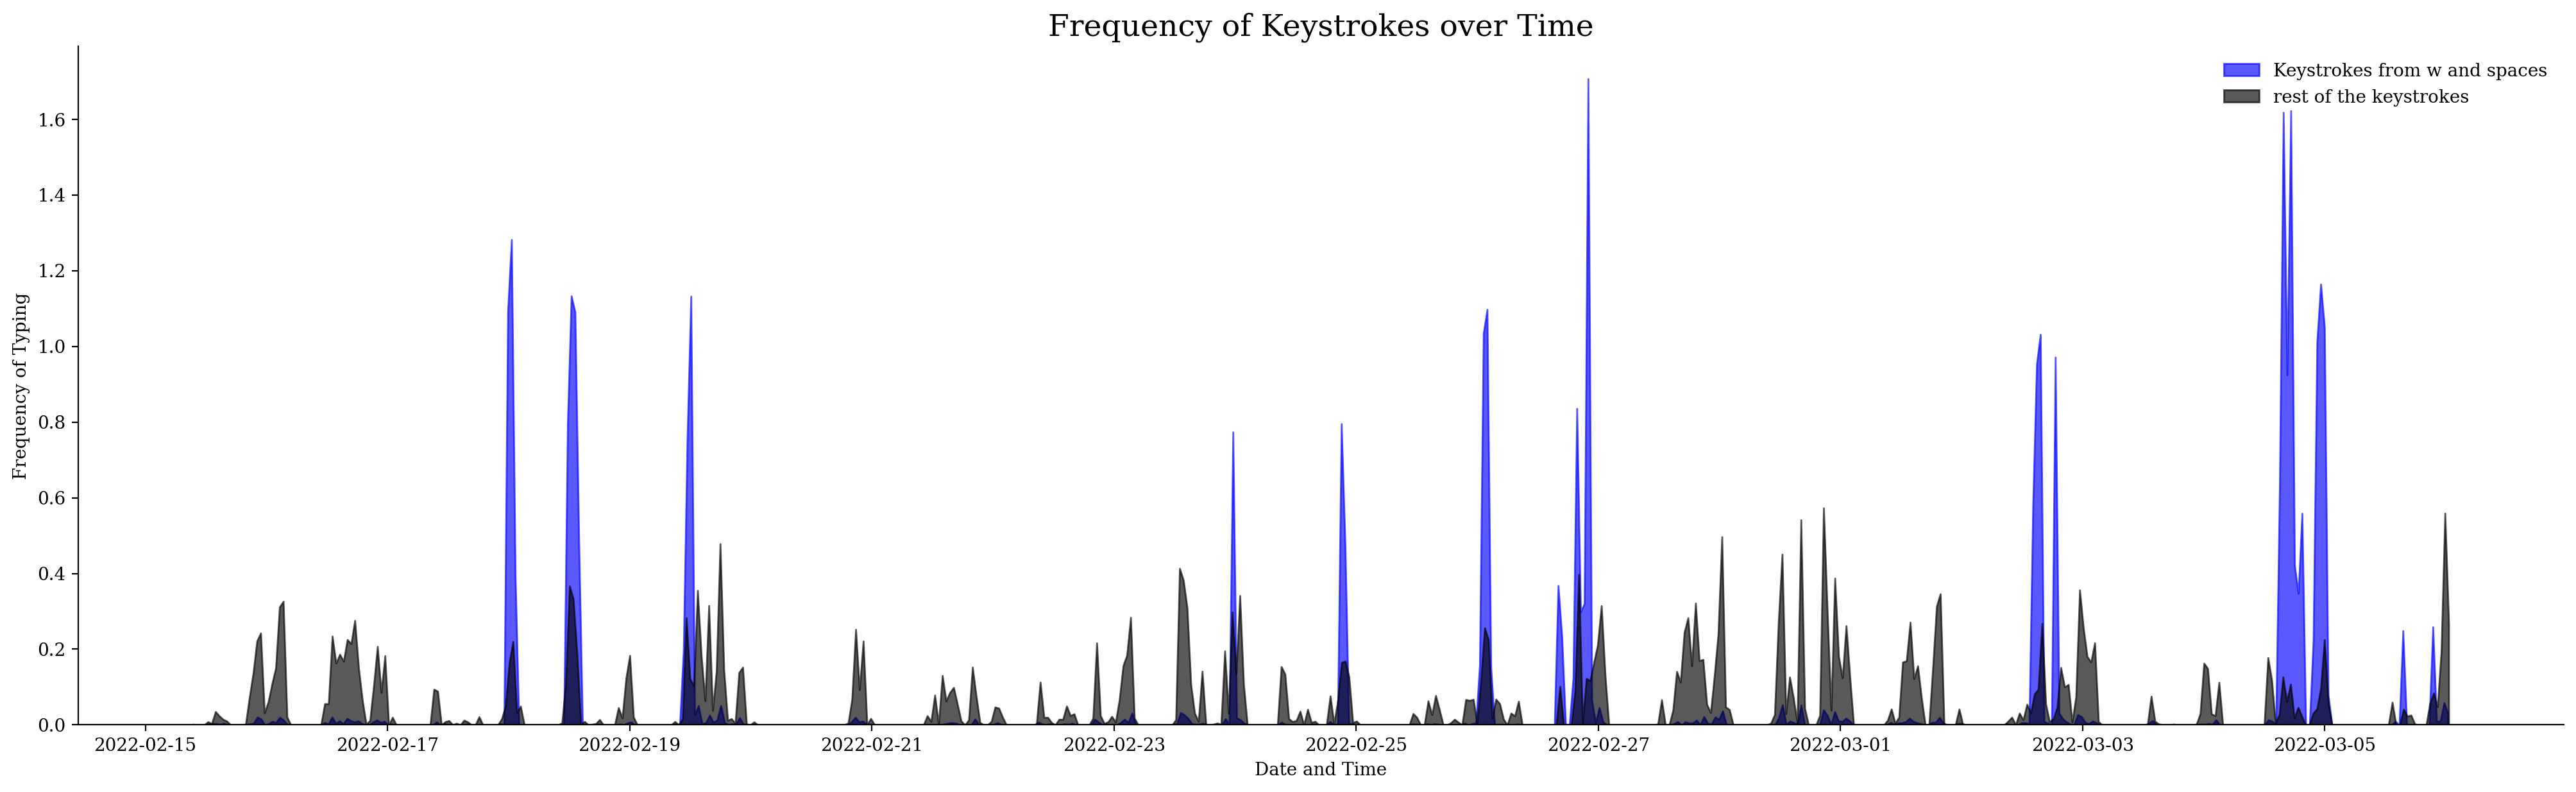

In [35]:
plt.rcParams["font.family"] = "serif"
# Plot a little histogram of the data 
# Create a figure
fig = plt.figure(figsize=(25,7),dpi=200)
ax = fig.add_subplot(111)

# Plot the histogram 
rest  = dates[np.where((data[0] != 13) * (data[0] != 49))]
Ws    = dates[np.where((data[0] == 13) + (data[0] == 49))]

n_w,x_w,_ = ax.hist(Ws,bins=600,alpha=0,color='b',density=True,histtype='stepfilled');
bins_w = 0.5*(x_w[1:]+x_w[:-1])
plt.fill_between(bins_w,n_w,color='b',alpha=0.65,label='Keystrokes from w and spaces')

n_r,x_r,_ = ax.hist(rest,bins=600,alpha=0,color='k',density=True,histtype='stepfilled');
bins_r = 0.5*(x_r[1:]+x_r[:-1])
plt.fill_between(bins_r,n_r,color='k',alpha=0.65,label='rest of the keystrokes')


# Some customization
ax.set_xlabel('Date and Time',fontsize=10);
ax.set_ylabel('Frequency of Typing',fontsize=10);

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Frequency of Keystrokes over Time',fontsize=17);
ax.legend(frameon=False)
# mpld3.save_html(fig,'test.html')

In [32]:
dates[np.where((data[0] == 13) + (data[0] == 49))]

array([datetime.datetime(2022, 2, 15, 12, 12, 5, 875780),
       datetime.datetime(2022, 2, 15, 12, 25, 11, 474060),
       datetime.datetime(2022, 2, 15, 13, 34, 4, 499600), ...,
       datetime.datetime(2022, 3, 6, 0, 35, 45, 336970),
       datetime.datetime(2022, 3, 6, 0, 44, 15, 89750),
       datetime.datetime(2022, 3, 6, 0, 47, 38, 462000)], dtype=object)

In [28]:
data[0]

array([ 36,  53,   3, ..., 124,  51,   8])